In [1]:
import sys, os
from models import FCN_model
from preprocessing import ConstantLengthDataGenerator, plot
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import mlflow
from preprocessing.utils import plot
import tensorflow as tf

mlflow.set_experiment("FCN")
mlflow.tensorflow.autolog()

In [2]:
data_path = "./data"
X, y = np.load(f"{data_path}/X.npy", allow_pickle=True), np.load(f"{data_path}/y.npy")
y.shape, X.shape

((60555, 1), (60555,))

In [3]:
mask = np.char.startswith(y, "NonInvasiveFetalECGThorax1").reshape(-1)
y = y[mask, :]
X = X[mask]
mlflow.log_param("y.unique", ", ".join(np.unique(y))[:500])

'NonInvasiveFetalECGThorax1_1, NonInvasiveFetalECGThorax1_10, NonInvasiveFetalECGThorax1_11, NonInvasiveFetalECGThorax1_12, NonInvasiveFetalECGThorax1_13, NonInvasiveFetalECGThorax1_14, NonInvasiveFetalECGThorax1_15, NonInvasiveFetalECGThorax1_16, NonInvasiveFetalECGThorax1_17, NonInvasiveFetalECGThorax1_18, NonInvasiveFetalECGThorax1_19, NonInvasiveFetalECGThorax1_2, NonInvasiveFetalECGThorax1_20, NonInvasiveFetalECGThorax1_21, NonInvasiveFetalECGThorax1_22, NonInvasiveFetalECGThorax1_23, NonInv'

In [4]:
y_encoder = sklearn.preprocessing.OneHotEncoder(categories="auto")
y = y_encoder.fit_transform(y.reshape(-1, 1)).toarray()
mlflow.log_param("y.shape", y.shape)
y.shape, X.shape

((1800, 42), (1800,))

In [5]:
number_of_classes = y.shape[1]
initial_learning_rate = 1e-4
output_directory = f"{data_path}/models/fcn/outputs"
batch_size = 256
os.makedirs(output_directory, exist_ok=True)

In [6]:
input_layer = keras.layers.Input(shape=(None, 1))
fcn_model = FCN_model(number_of_classes=number_of_classes)(input_layer)
model = keras.models.Model(inputs=input_layer, outputs=fcn_model)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, decay_steps=3, decay_rate=1
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr_schedule),
    metrics=["accuracy"],
)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         1536      
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 128)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 256)         164096    
                                                                 
 batch_normalization_1 (Batc  (None, None, 256)        1024      
 hNormalization)                                             

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

In [9]:
kwargs = {"min_length": 256, "max_length": 256, "logging_call": mlflow.log_params}
data_generator_train = ConstantLengthDataGenerator(
    X_train,
    y_train,
    batch_size=batch_size,
    augmentation_probability=0.1,
    cutting_probability=0.1,
    padding_probability=0.9,
    **kwargs
)
data_generator_val = ConstantLengthDataGenerator(
    X_val,
    y_val,
    batch_size=len(y_val),
    augmentation_probability=0,
    cutting_probability=0,
    padding_probability=1,
    **kwargs
)
validation_data = next(data_generator_val)

In [10]:
history = model.fit(data_generator_train, epochs=100, validation_data=validation_data)

Epoch 1/100
60/60 [==============================] - 83s 1s/step - loss: 3.7096 - accuracy: 0.0437 - val_loss: 3.7442 - val_accuracy: 0.0289
Epoch 2/100
60/60 [==============================] - 79s 1s/step - loss: 3.5486 - accuracy: 0.0824 - val_loss: 3.7608 - val_accuracy: 0.0289
Epoch 3/100
60/60 [==============================] - 80s 1s/step - loss: 3.3712 - accuracy: 0.1389 - val_loss: 3.7747 - val_accuracy: 0.0289
Epoch 4/100
60/60 [==============================] - 81s 1s/step - loss: 3.2192 - accuracy: 0.2111 - val_loss: 3.8017 - val_accuracy: 0.0289
Epoch 5/100
60/60 [==============================] - 82s 1s/step - loss: 3.0891 - accuracy: 0.3034 - val_loss: 3.7829 - val_accuracy: 0.0689
Epoch 6/100
60/60 [==============================] - 83s 1s/step - loss: 2.9886 - accuracy: 0.3894 - val_loss: 3.7383 - val_accuracy: 0.0689
Epoch 7/100
60/60 [==============================] - 84s 1s/step - loss: 2.9562 - accuracy: 0.4283 - val_loss: 3.6037 - val_accuracy: 0.0622
Epoch 8/100
6

Epoch 59/100
60/60 [==============================] - 83s 1s/step - loss: 1.1367 - accuracy: 0.8046 - val_loss: 0.9103 - val_accuracy: 0.8333
Epoch 60/100
60/60 [==============================] - 83s 1s/step - loss: 1.0982 - accuracy: 0.8084 - val_loss: 0.9926 - val_accuracy: 0.7178
Epoch 61/100
60/60 [==============================] - 83s 1s/step - loss: 1.1036 - accuracy: 0.8049 - val_loss: 0.9758 - val_accuracy: 0.7800
Epoch 62/100
60/60 [==============================] - 83s 1s/step - loss: 0.9945 - accuracy: 0.8318 - val_loss: 0.9653 - val_accuracy: 0.7667
Epoch 63/100
60/60 [==============================] - 83s 1s/step - loss: 1.0581 - accuracy: 0.8110 - val_loss: 0.8574 - val_accuracy: 0.8200
Epoch 64/100
60/60 [==============================] - 83s 1s/step - loss: 1.0952 - accuracy: 0.8061 - val_loss: 0.8639 - val_accuracy: 0.8089
Epoch 65/100
60/60 [==============================] - 83s 1s/step - loss: 1.0783 - accuracy: 0.8084 - val_loss: 0.8552 - val_accuracy: 0.8422
Epoch 

INFO:tensorflow:Assets written to: C:\Users\pacyn\AppData\Local\Temp\tmp2ggq6ho0\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\pacyn\AppData\Local\Temp\tmp2ggq6ho0\model\data\model\assets
2023/01/24 13:32:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\pacyn\miniconda3\envs\uni\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."


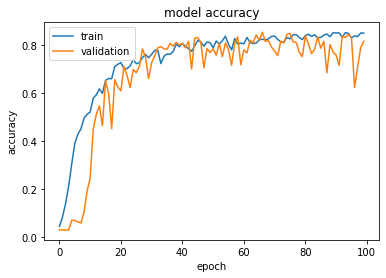

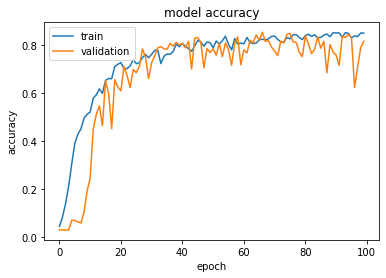

In [11]:
figure = plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
figure

In [12]:
mlflow.log_figure(figure, "data/figures/acc.png")

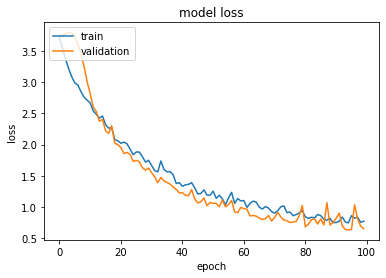

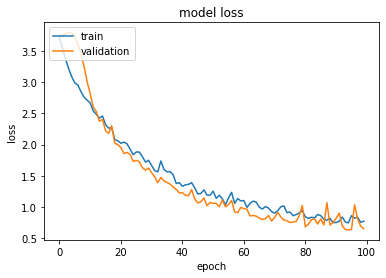

In [13]:
figure = plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
figure

In [14]:
mlflow.log_figure(figure, "data/figures/loss.png")

In [15]:
mlflow.log_artifact("models")
mlflow.log_artifact("preprocessing")

15/15 [==============================] - 1s 37ms/step


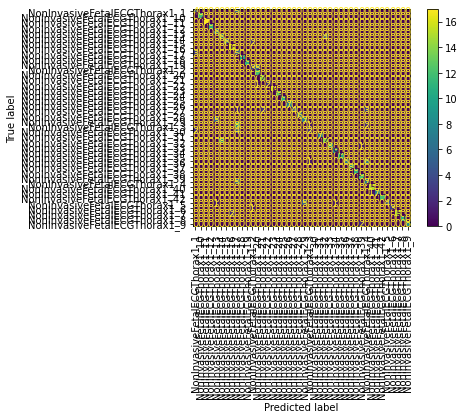

In [16]:
y_prediction = model.predict(validation_data[0])
 
fig = ConfusionMatrixDisplay.from_predictions(y_encoder.inverse_transform(validation_data[1]),
                     y_encoder.inverse_transform(y_prediction),
    display_labels=y_encoder.categories_[0],
    xticks_rotation='vertical'
) 
mlflow.log_figure(fig.figure_, "data/figures/conf.png")

In [17]:
mlflow.end_run()